In [56]:
import os
import pathlib
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard module is not an IPython extension.


In [5]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

train_images_dir = os.path.abspath('../data/train/images/')
train_masks_dir = os.path.abspath('../data/train/masks/')
logdir = os.path.abspath(os.path.join('../result/', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
model_dir = os.path.join(logdir, 'model')
model_path = os.path.join(model_dir, 'model_best.h5')
tb_path = os.path.join(logdir, 'tensorboard')

pathlib.Path(model_dir).mkdir(parents=True, exist_ok=True)
pathlib.Path(tb_path).mkdir(parents=True, exist_ok=True)

In [6]:
ids = next(os.walk(train_images_dir))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  429


In [26]:
X = np.zeros((len(ids*6), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids*6), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [38]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(os.path.join(train_images_dir, id_), grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img(os.path.join(train_masks_dir, id_.split('.')[0]+'.png'), grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0
    
    # Flip
    flipped_x_img = np.fliplr(x_img)
    flipped_mask = np.fliplr(mask)
    X[1*len(ids)+n] = flipped_x_img/255.0
    y[1*len(ids)+n] = flipped_mask/255.0
    
    # Shifting Left
    shifted_x_img = np.copy(x_img)    
    for j in range(128):
      for i in range(128):
        if (i > 20):
          shifted_x_img[j][i] = x_img[j][i-20] 
        else:
          shifted_x_img[j][i] = x_img[j][128+i-20-1]
    X[2*len(ids)+n] = shifted_x_img/255.0    
    
    shifted_mask = np.copy(mask)
    for j in range(128):
      for i in range(128):
        if (i > 20):
          shifted_mask[j][i] = mask[j][i-20] 
        else:
          shifted_mask[j][i] = mask[j][128+i-20-1] 
    y[2*len(ids)+n] = shifted_mask/255.0
    
    # Shifting Right
    shiftedr_x_img = np.copy(x_img)
    for j in range(128):
      for i in range(128):
        if (i < 128-20):
          shiftedr_x_img[j][i] = x_img[j][i+20]
        else:            
          shiftedr_x_img[j][i] = x_img[j][20-(128-i)]
    X[3*len(ids)+n] = shiftedr_x_img/255.0
    
    shiftedr_mask = np.copy(mask)
    for j in range(128):
      for i in range(128):
        if (i < 128-20):
          shiftedr_mask[j][i] = mask[j][i+20]
        else:            
          shiftedr_mask[j][i] = mask[j][20-(128-i)]   
    y[3*len(ids)+n] = shiftedr_mask/255.0
    
    # Shifting Up
    shiftedu_x_img = np.copy(x_img)
    for j in range(128):
      for i in range(128):
        if (j > 20):
          shiftedu_x_img[j][i] = x_img[j-20][i] 
        else:
          shiftedu_x_img[j][i] = x_img[128+j-20-1][i]
    X[4*len(ids)+n] = shiftedu_x_img/255.0
    
    shiftedu_mask = np.copy(mask)
    for j in range(128):
      for i in range(128):
        if (j > 20):
          shiftedu_mask[j][i] = mask[j-20][i] 
        else:
          shiftedu_mask[j][i] = mask[128+j-20-1][i]
    y[4*len(ids)+n] = shiftedu_mask/255.0
    
    # Shifting Down
    shiftedd_x_img = np.copy(x_img)
    for j in range(128):
      for i in range(128):
        if (j < 128-20):
          shiftedd_x_img[j][i] = x_img[j+20][i]
        else:            
          shiftedd_x_img[j][i] = x_img[20-(128-j)][i]
    X[5*len(ids)+n] = shiftedd_x_img/255.0
    
    shiftedd_mask = np.copy(mask)
    for j in range(128):
      for i in range(128):
        if (j < 128-20):
          shiftedd_mask[j][i] = mask[j+20][i]
        else:            
          shiftedd_mask[j][i] = mask[20-(128-j)][i] 
    y[5*len(ids)+n] = shiftedd_mask/255.0

Text(0.5, 1.0, 'Shift right')

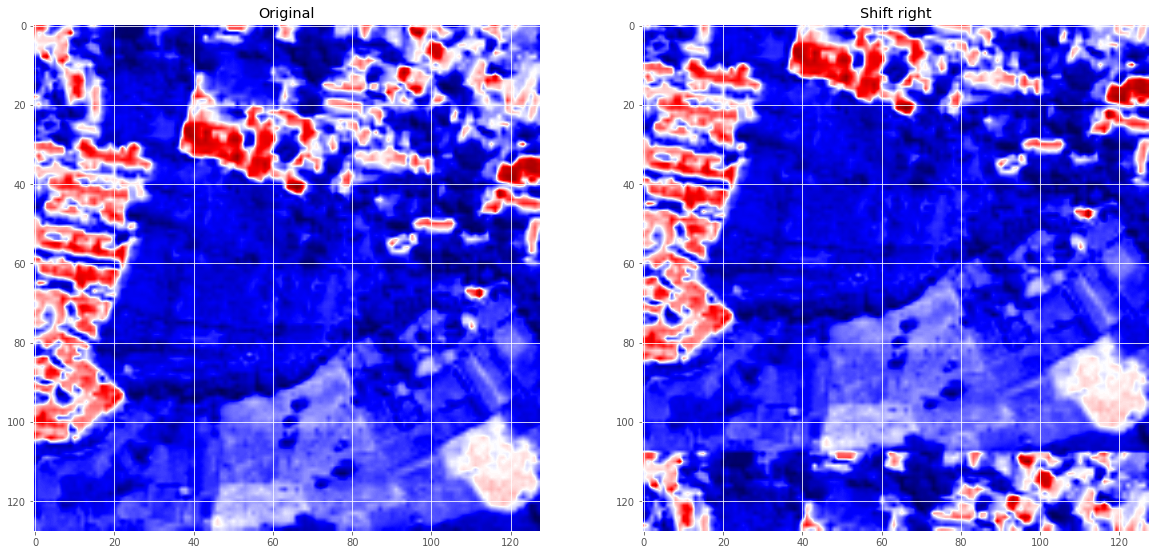

In [39]:
# Visualize any randome image along with the mask
ix = 4
ix_aug = 5*len(ids)+ix
has_mask = y[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
ax1.set_title('Original')

ax2.imshow(X[ix_aug, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
ax2.set_title('Shift right')

In [53]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

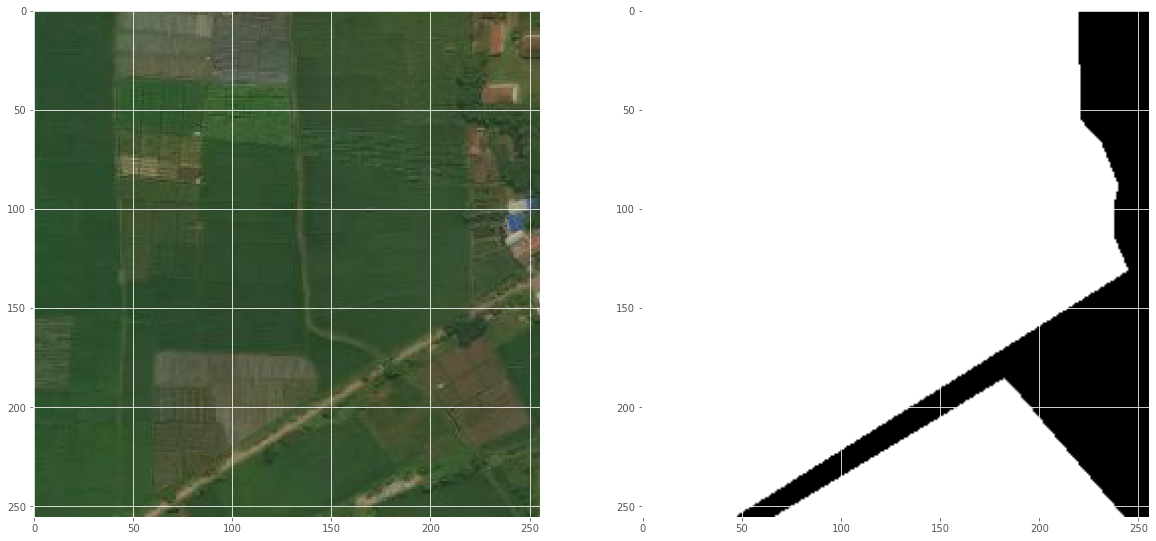

In [44]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(ids))
img = load_img(os.path.join(train_images_dir, ids[ix]))
mask = load_img(os.path.join(train_masks_dir, ids[ix].split('.')[0]+'.png'), grayscale=True)
# has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
ax1.imshow(img)
ax2.imshow(mask, cmap = 'gray', interpolation = 'bilinear')

Text(0.5, 1.0, 'Salt')

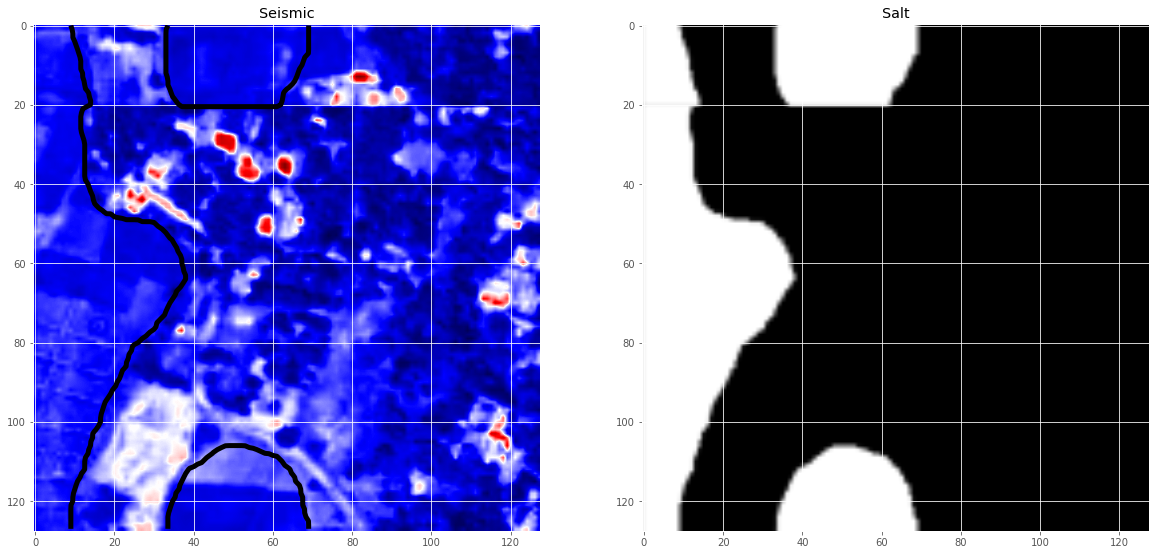

In [45]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
# ax1.imshow(X_train[ix, ..., 0])
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [46]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [47]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [48]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [49]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

In [59]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, save_weights_only=True), 
    tf.keras.callbacks.TensorBoard(tb_path, histogram_freq=1, write_graph=True, write_images=True)
]

In [60]:
keras.backend.get_session().run(tf.global_variables_initializer())

In [61]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 2059 samples, validate on 515 samples
Epoch 1/50
2059/2059 [==============================] - 620s 301ms/step - loss: 0.4406 - acc: 0.7695 - val_loss: 0.4175 - val_acc: 0.7705

Epoch 00001: val_loss improved from inf to 0.41754, saving model to /run/media/soedomoto/DATA/PROJECT/2019-ICAS2019/result/20191109-230440/model/model_best.h5
Epoch 2/50
2059/2059 [==============================] - 579s 281ms/step - loss: 0.3589 - acc: 0.8097 - val_loss: 0.4490 - val_acc: 0.7799

Epoch 00002: val_loss did not improve
Epoch 3/50
2059/2059 [==============================] - 518s 251ms/step - loss: 0.3361 - acc: 0.8146 - val_loss: 0.3772 - val_acc: 0.8036

Epoch 00003: val_loss improved from 0.41754 to 0.37722, saving model to /run/media/soedomoto/DATA/PROJECT/2019-ICAS2019/result/20191109-230440/model/model_best.h5
Epoch 4/50
2059/2059 [==============================] - 503s 244ms/step - loss: 0.3139 - acc: 0.8257 - val_loss: 0.3243 - val_acc: 0.8266

Epoch 00004: val_loss improved from 0

2059/2059 [==============================] - 494s 240ms/step - loss: 0.1790 - acc: 0.8852 - val_loss: 0.2486 - val_acc: 0.8572

Epoch 00037: val_loss did not improve
Epoch 38/50
2059/2059 [==============================] - 495s 240ms/step - loss: 0.1759 - acc: 0.8864 - val_loss: 0.2429 - val_acc: 0.8606

Epoch 00038: val_loss did not improve
Epoch 39/50
2059/2059 [==============================] - 494s 240ms/step - loss: 0.1760 - acc: 0.8863 - val_loss: 0.2553 - val_acc: 0.8538

Epoch 00039: val_loss did not improve
Epoch 40/50
2059/2059 [==============================] - 492s 239ms/step - loss: 0.1756 - acc: 0.8869 - val_loss: 0.2364 - val_acc: 0.8636

Epoch 00040: val_loss did not improve
Epoch 41/50
2059/2059 [==============================] - 491s 239ms/step - loss: 0.1755 - acc: 0.8863 - val_loss: 0.2514 - val_acc: 0.8576

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00041: val_loss did not improve
Epoch 42/50
2059/2059 [=================

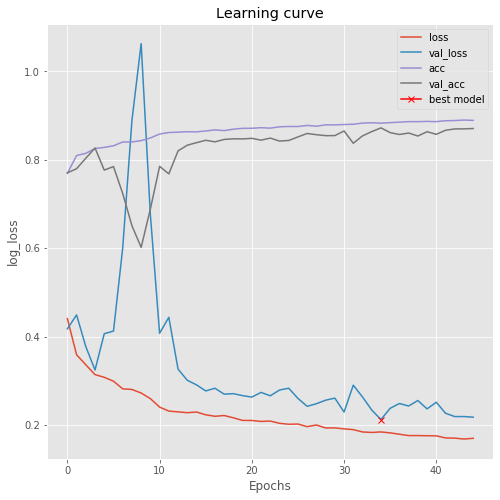

In [95]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(results.history["acc"], label="acc")
plt.plot(results.history["val_acc"], label="val_acc")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [ ]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [63]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

515/515 [==============================] - 44s 85ms/step


[0.21762409045279604, 0.8707852556867507]

In [64]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

515/515 [==============================] - 42s 82ms/step


In [65]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [66]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

### Predictions on training set

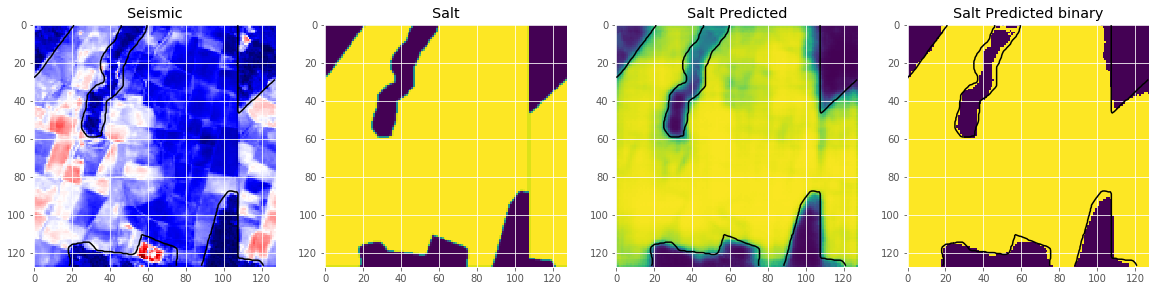

In [67]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

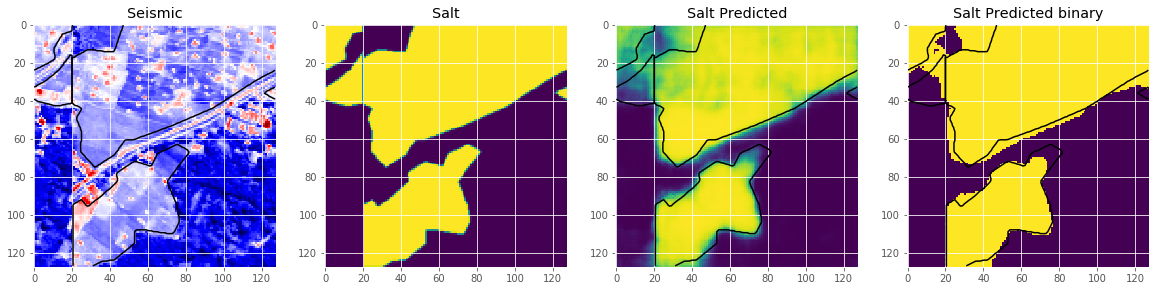

In [68]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

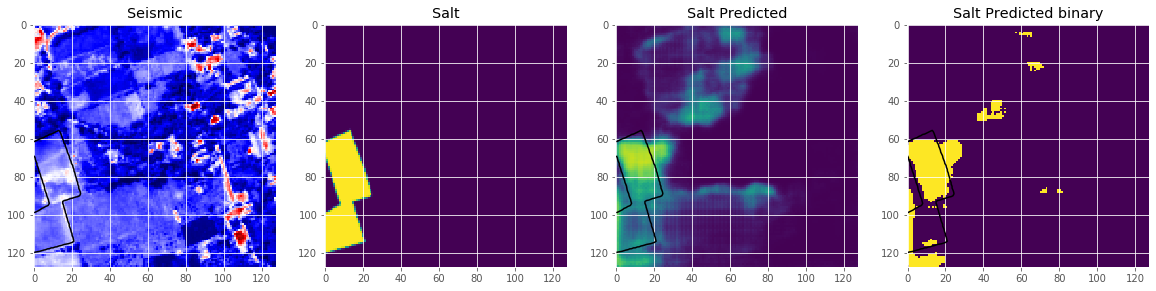

In [69]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

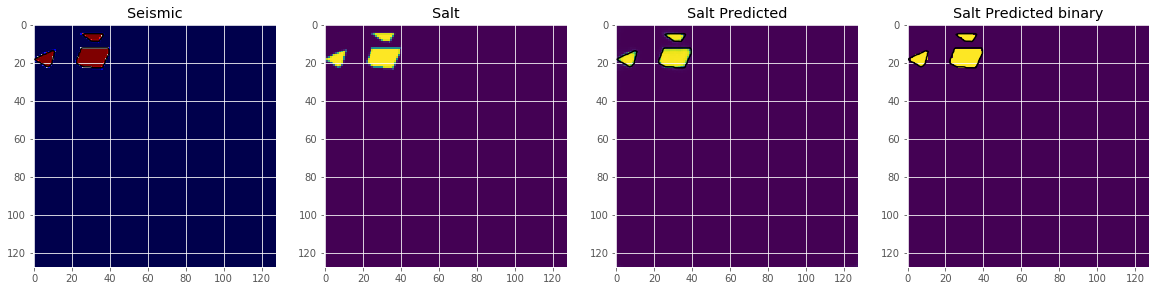

In [70]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

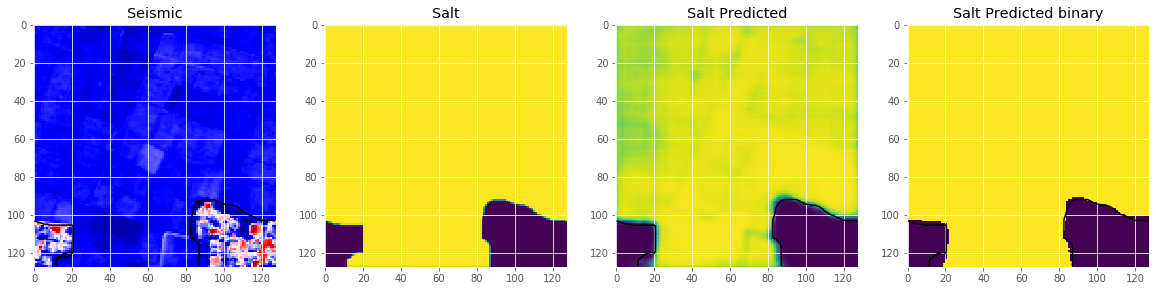

In [71]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

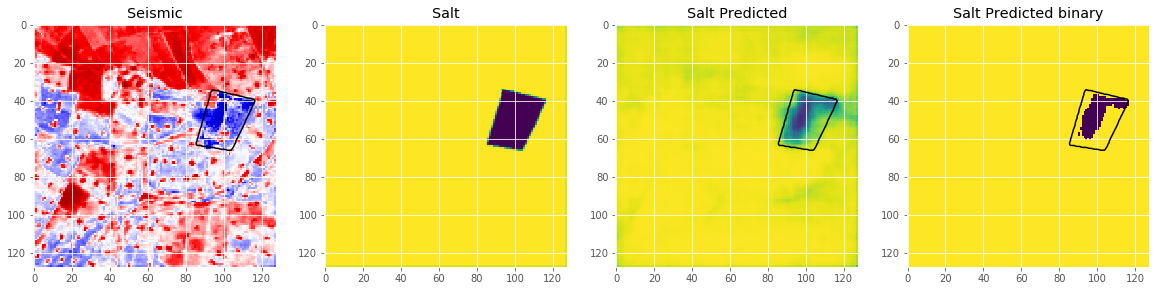

In [72]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

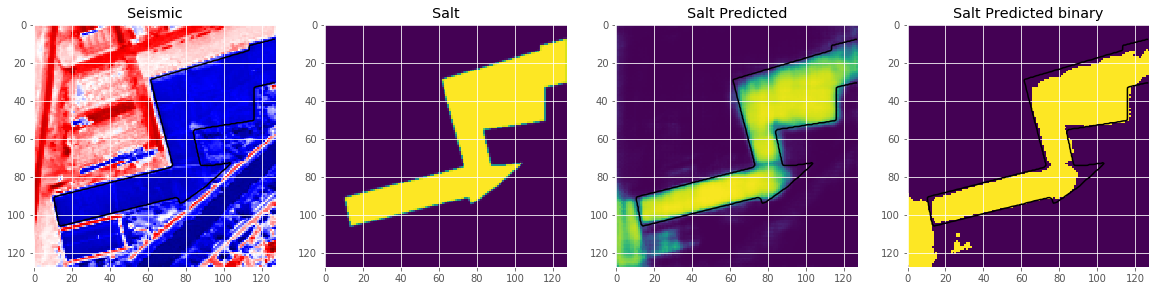

In [73]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

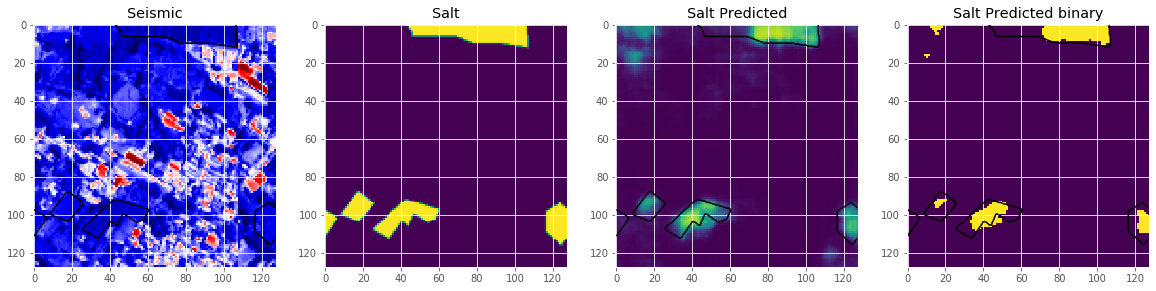

In [74]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

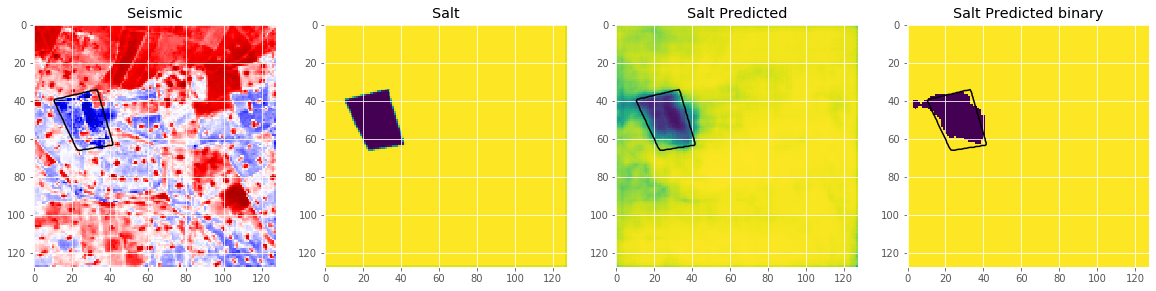

In [75]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

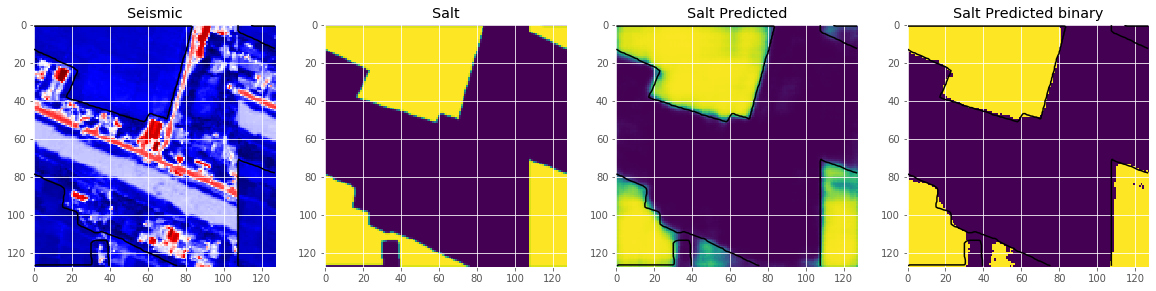

In [76]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

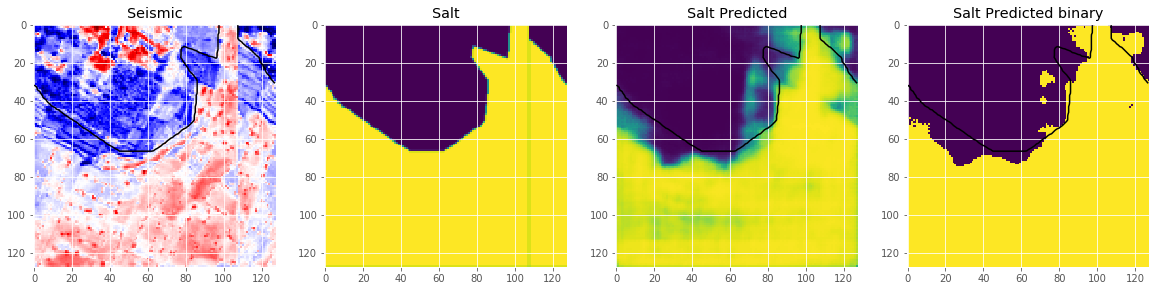

In [77]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

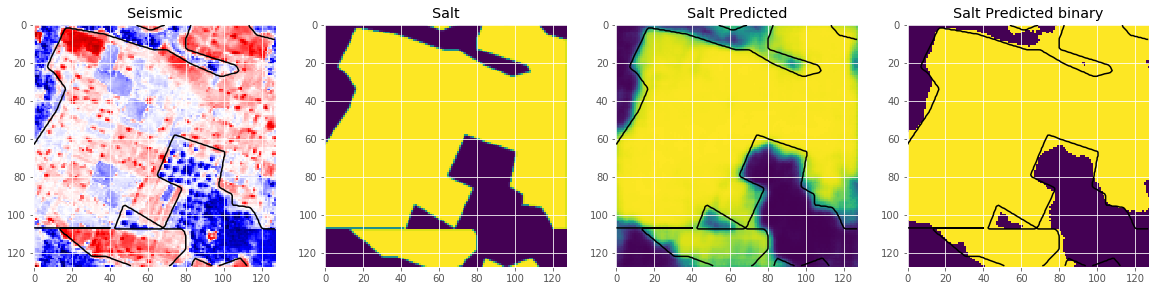

In [78]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

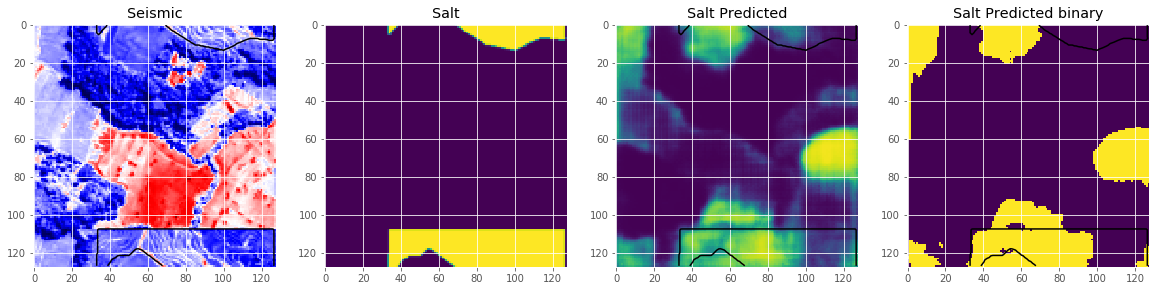

In [79]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

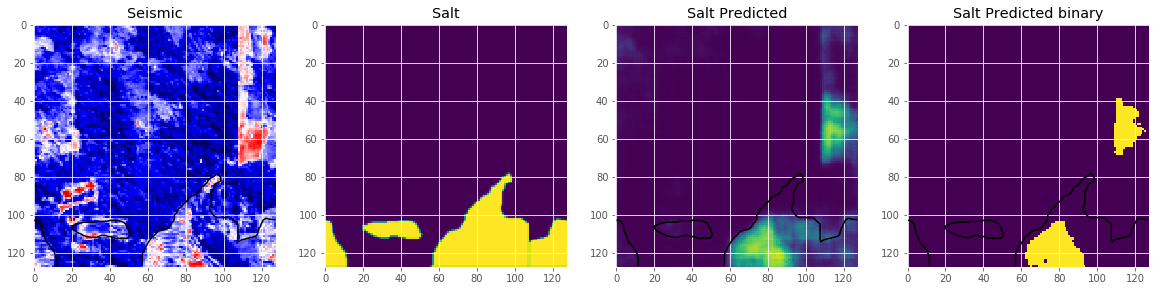

In [80]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

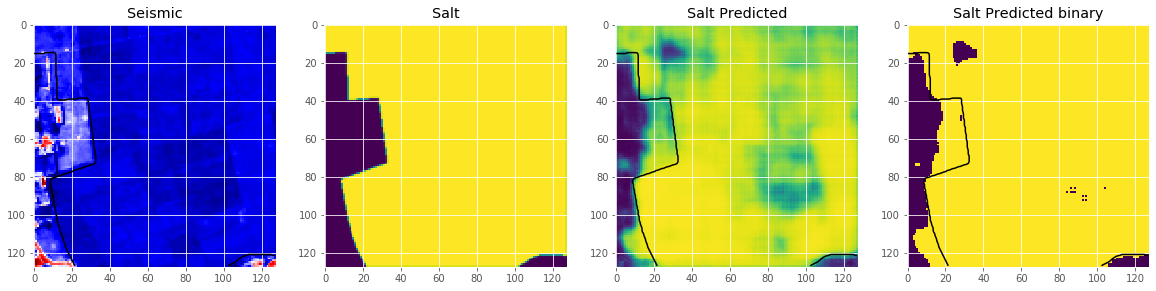

In [81]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

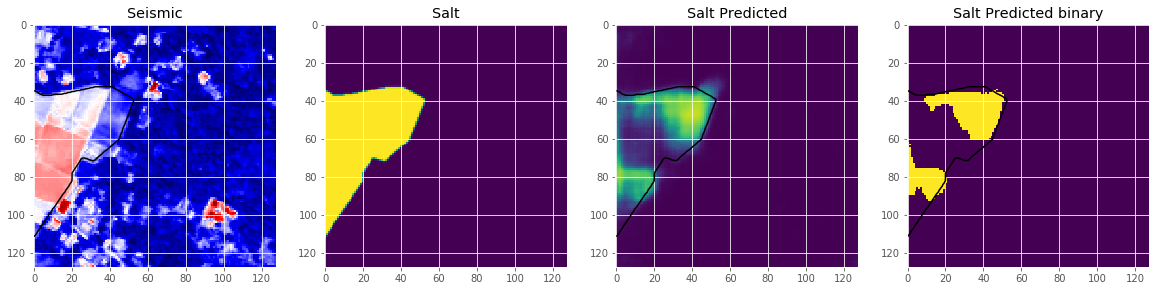

In [82]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

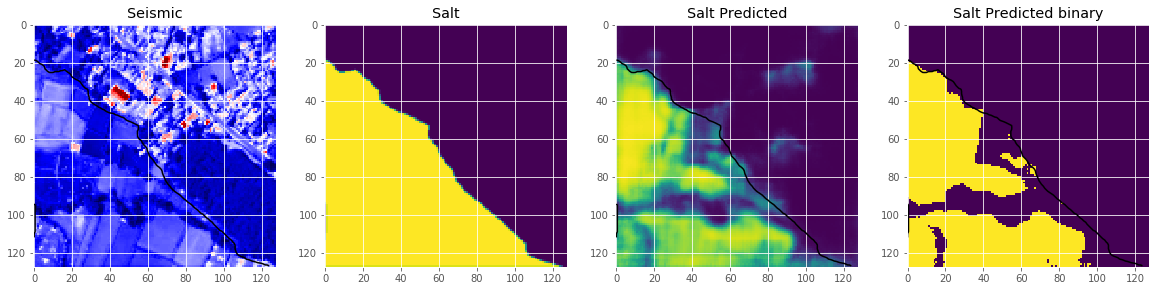

In [83]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

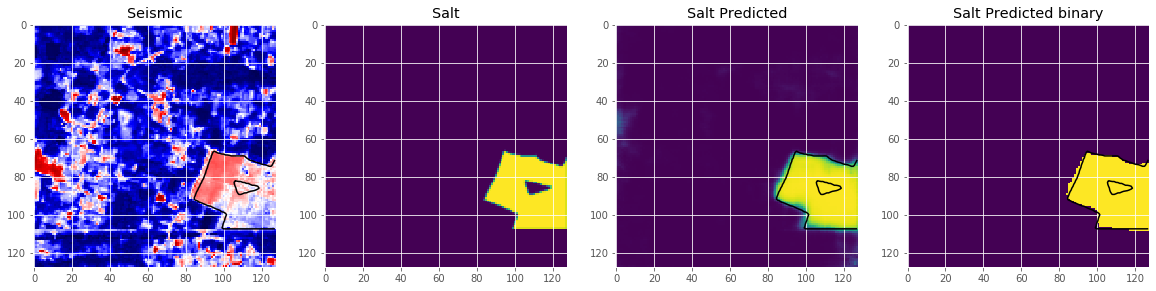

In [84]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

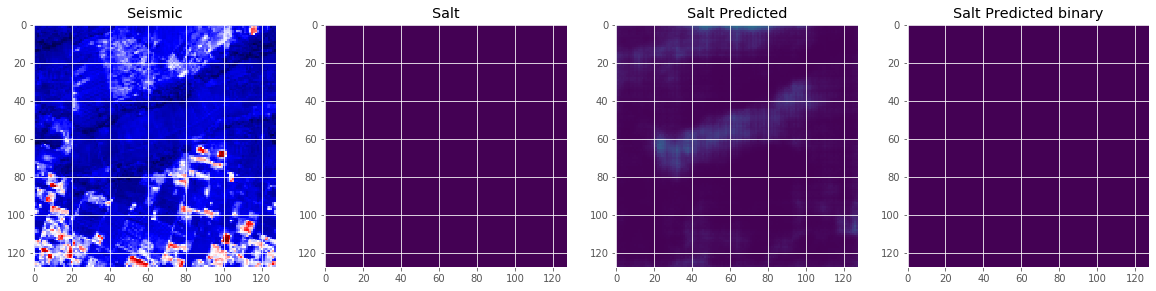

In [85]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

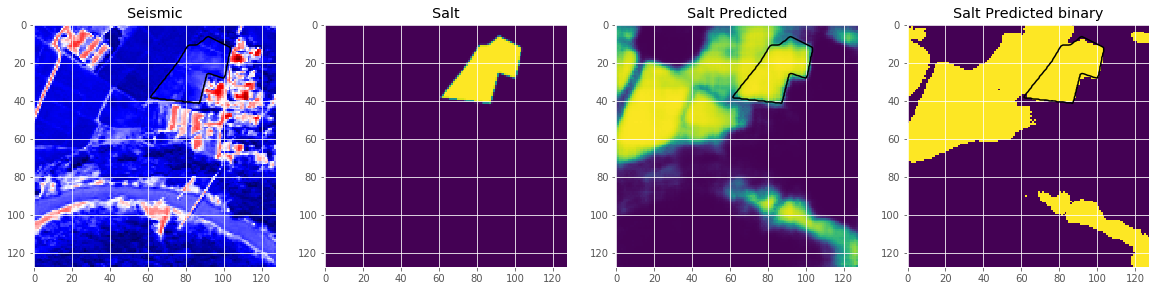

In [86]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

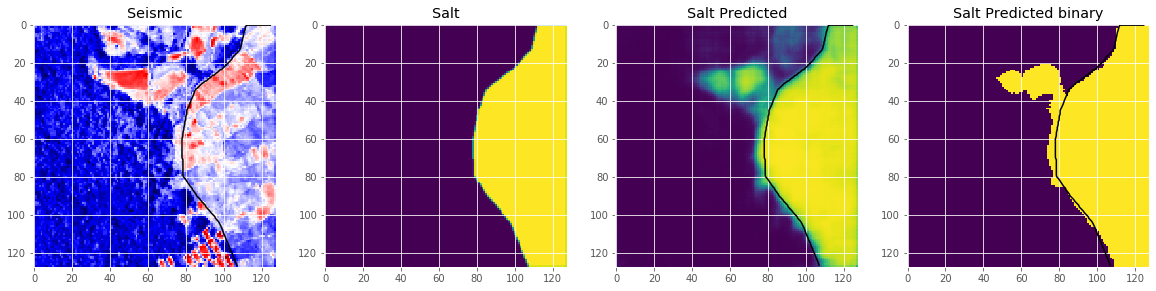

In [87]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

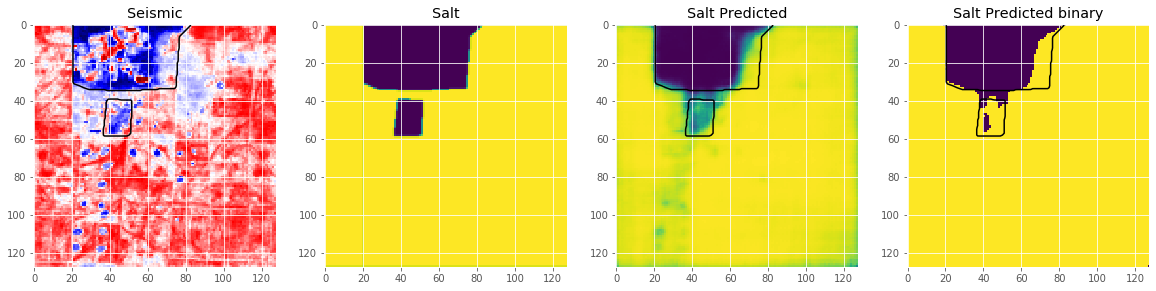

In [88]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

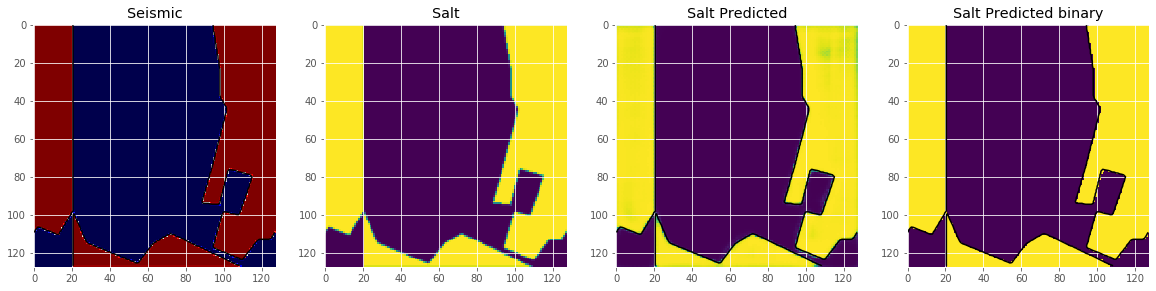

In [89]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

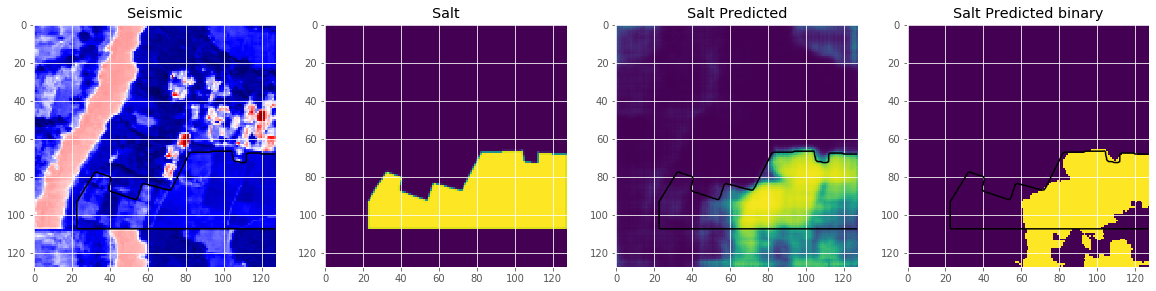

In [90]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

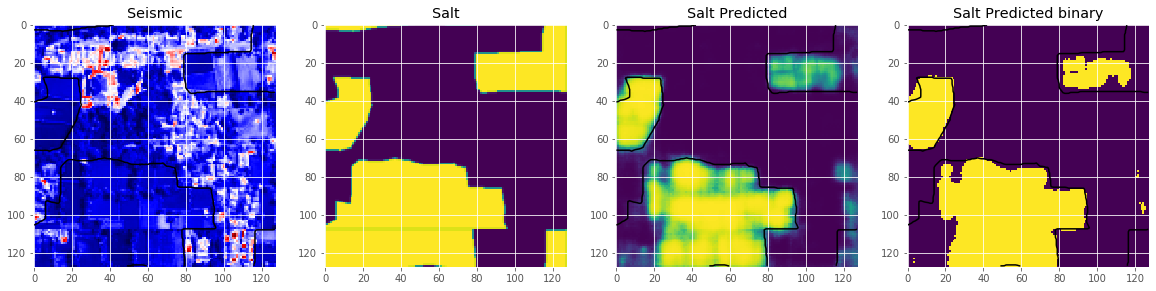

In [91]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

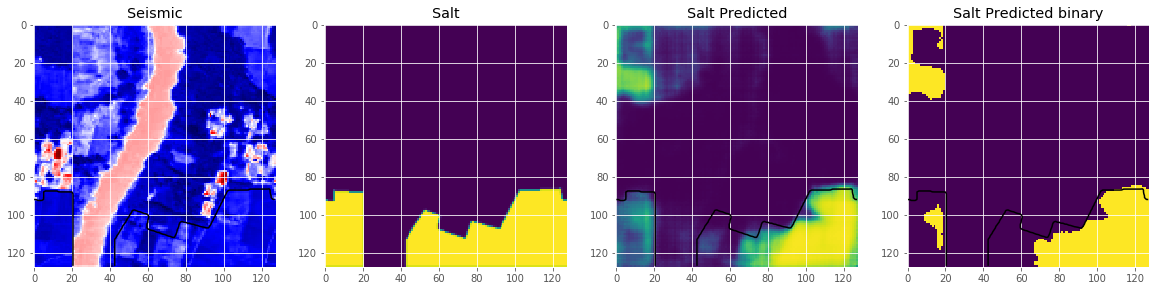

In [92]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

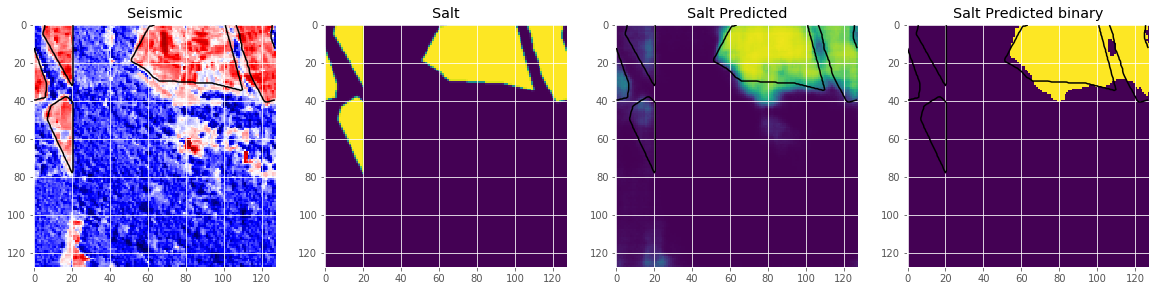

In [93]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

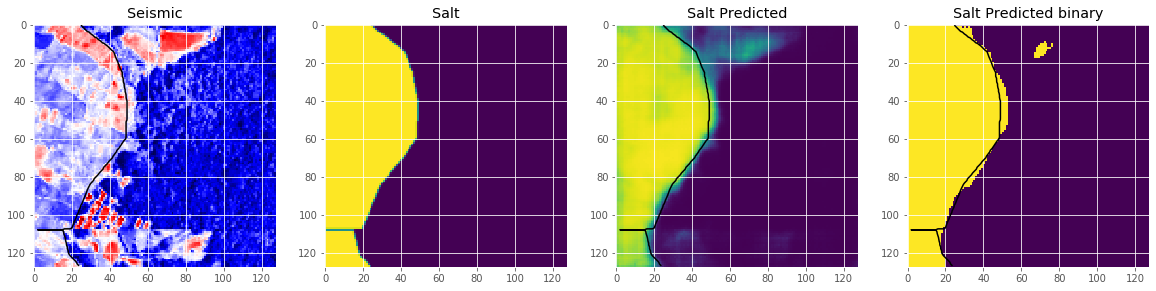

In [94]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)